# **Expense Structure and Cost Pressure in Bankrupt Firms (1999–2009 Taiwan)**

**Dataset Description:**

The dataset contains financial and operational data collected from the Taiwan Economic
Journal for the years 1999 to 2009. It focuses on companies listed on the Taiwan Stock
Exchange, with bankruptcy status defined according to official business regulations.

**Goal**

To examine whether cost structure inefficiencies contribute to bankruptcy risk even when revenues exist.

**Key Analysis Questions**
*   Do bankrupt firms show consistently higher operating expense ratios?
*   Is Total Expense to Assets a stronger signal than profit ratios?
*   Can high costs explain failure despite stable sales?

**Key Columns**
*   Operating Expense Rate
*   Total Expense / Assets
*   Gross Profit to Sales
*   Operating Profit Rate

In addition to core cost structure variables, related profitability, cash flow, liquidity, and efficiency indicators will be explored for comparison.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

In [2]:
drive.mount('/content/drive')

path = '/content/drive/MyDrive/DS/Project/data.csv'
data = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data.shape

(6819, 96)

In [4]:
data.head(1)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.40575,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.82789,0.290202,0.026601,0.56405,1,0.016469


#Data Cleaning

In [5]:
data['Bankrupt?'].value_counts()

,count
Bankrupt?,
0,6599
1,220


In [6]:
data['Bankrupt?'].value_counts(normalize=True)


,proportion
Bankrupt?,
0,0.967737
1,0.032263


The dataset exhibits class imbalance, with bankrupt firms representing a *minority* of observations.

In [7]:
data.columns = data.columns.str.strip()
data.columns

Index(['Bankrupt?', 'ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

In [8]:
data.dtypes.value_counts()

,count
float64,93
int64,3


In [9]:
data.isna().sum().sort_values(ascending=False).head(15)

,0
Bankrupt?,0
ROA(C) before interest and depreciation before interest,0
ROA(A) before interest and % after tax,0
ROA(B) before interest and depreciation after tax,0
Operating Gross Margin,0
Realized Sales Gross Margin,0
Operating Profit Rate,0
Pre-tax net Interest Rate,0
After-tax net Interest Rate,0
Non-industry income and expenditure/revenue,0


In [10]:
data.isnull().sum().sum()

np.int64(0)

In [11]:
data.duplicated().sum()

np.int64(0)

#Feature Group

In [12]:
target = 'Bankrupt?'

cost_features = [
    'Operating Expense Rate',
    'Interest Expense Ratio',
    'Research and development expense rate',
    'Total expense/Assets',
    'Total income/Total expense'
]

profit_features = [
    'Operating Profit Rate',
    'Gross Profit to Sales',
    'Net Income to Total Assets',
    'ROA(A) before interest and % after tax',
    'ROA(B) before interest and depreciation after tax',
    'ROA(C) before interest and depreciation before interest'
]

revenue_efficiency_features = [
    'Total Asset Turnover',
    'Revenue per person',
    'Operating profit per person',
    'Revenue Per Share (Yuan ¥)'
]

cashflow_features = [
    'Cash Flow to Total Assets',
    'Cash Flow to Sales',
    'CFO to Assets',
    'Cash Flow to Liability'
]

liquidity_features = [
    'Current Ratio',
    'Quick Ratio',
    'Cash/Current Liability'
]

In [13]:
def group_summary(df, features, target):
    rows = []
    for col in features:
        b = df[df[target] == 1][col]
        nb = df[df[target] == 0][col]

        rows.append({
            'Variable': col,
            'Median_Bankrupt': b.median(),
            'Median_NonBankrupt': nb.median(),
            'Mean_Bankrupt': b.mean(),
            'Mean_NonBankrupt': nb.mean(),
            'Median_Diff': b.median() - nb.median(),
            'IQR_Bankrupt': b.quantile(0.75) - b.quantile(0.25),
            'IQR_NonBankrupt': nb.quantile(0.75) - nb.quantile(0.25)
        })

    out = pd.DataFrame(rows)
    out['Abs_Median_Diff'] = out['Median_Diff'].abs()
    return out.sort_values('Abs_Median_Diff', ascending=False)

In [14]:
cost_summary = group_summary(data, cost_features, target)

In [15]:
profit_summary = group_summary(data, profit_features, target)

In [16]:
revenue_summary = group_summary(data, revenue_efficiency_features, target)

In [17]:
cashflow_summary = group_summary(data, cashflow_features, target)

In [18]:
liquidity_summary = group_summary(data, liquidity_features, target)

In [19]:
cost_summary

,Variable,Median_Bankrupt,Median_NonBankrupt,Mean_Bankrupt,Mean_NonBankrupt,Median_Diff,IQR_Bankrupt,IQR_NonBankrupt,Abs_Median_Diff
2,Research and development expense rate,1.545000e+08,5.430000e+08,1.605623e+09,1.961923e+09,-3.885000e+08,2.662500e+09,3.460000e+09,3.885000e+08
3,Total expense/Assets,3.203501e-02,2.253927e-02,4.985763e-02,2.849488e-02,9.495742e-03,3.812408e-02,2.093114e-02,9.495742e-03
1,Interest Expense Ratio,6.302828e-01,6.307033e-01,6.308260e-01,6.309965e-01,-4.205425e-04,1.039969e-03,5.143765e-04,4.205425e-04
4,Total income/Total expense,2.047533e-03,2.343043e-03,2.076301e-03,2.564703e-03,-2.955095e-04,1.996270e-04,2.552985e-04,2.955095e-04
0,Operating Expense Rate,3.354035e-04,2.762560e-04,1.887486e+09,1.998943e+09,5.914750e-05,2.932500e+09,4.155000e+09,5.914750e-05


## Total Expense/Assets





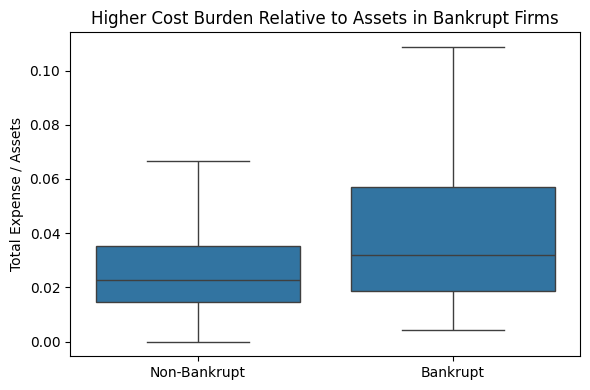

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=data,
    x='Bankrupt?',
    y='Total expense/Assets',
    showfliers=False
)

plt.xticks([0,1], ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('')
plt.ylabel('Total Expense / Assets')
plt.title('Higher Cost Burden Relative to Assets in Bankrupt Firms')
plt.tight_layout()
plt.show()

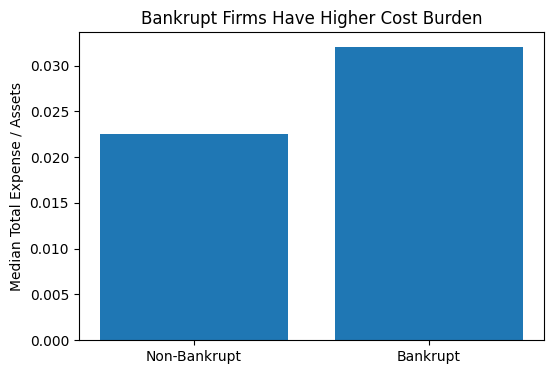

In [21]:
median_values = data.groupby('Bankrupt?')['Total expense/Assets'].median()

plt.figure(figsize=(6,4))
plt.bar(['Non-Bankrupt', 'Bankrupt'], median_values)

plt.ylabel('Median Total Expense / Assets')
plt.title('Bankrupt Firms Have Higher Cost Burden')
plt.show()


Bankrupt firms consistently operate with a higher expense burden relative to their assets, indicating structural cost pressure that makes them more vulnerable to failure.

### Gross Profit to Sales

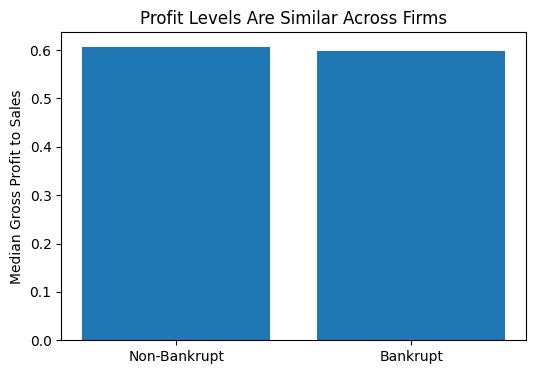

In [22]:
profit_median = data.groupby('Bankrupt?')['Gross Profit to Sales'].median()

plt.figure(figsize=(6,4))
plt.bar(['Non-Bankrupt', 'Bankrupt'], profit_median)

plt.ylabel('Median Gross Profit to Sales')
plt.title('Profit Levels Are Similar Across Firms')
plt.show()

* Bankrupt firms have a close or same profit range
* They are not all low-profit firms

This means Bankruptcy does NOT require profits to be zero or negative.

# **cost x liquidity**

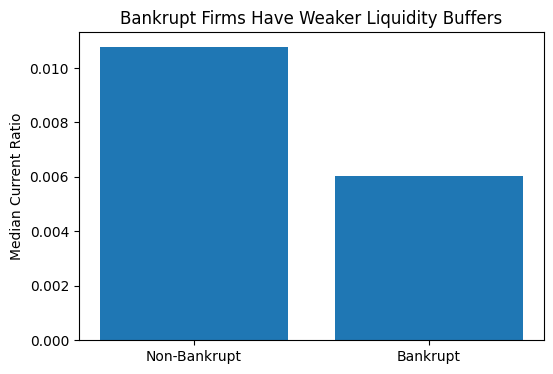

In [23]:
liq_median = data.groupby('Bankrupt?')['Current Ratio'].median()

plt.figure(figsize=(6,4))
plt.bar(['Non-Bankrupt', 'Bankrupt'], liq_median)
plt.ylabel('Median Current Ratio')
plt.title('Bankrupt Firms Have Weaker Liquidity Buffers')
plt.show()

# Key Findings

1. Profitability levels were similar between bankrupt and non-bankrupt firms, indicating that firms often continued generating revenue before failure.

2. Bankrupt firms showed a higher Total Expense relative to Assets, meaning a larger share of their resources was consumed by operating costs.

3. Weaker liquidity limited these firms’ ability to absorb sustained cost pressure.

4. Bankruptcy appears to emerge gradually from structural imbalance rather than sudden loss of income.
<br>

Failure is less about declining revenue and more about costs becoming unsustainably heavy relative to available resources.